In [1]:
import networkx as nx
import numpy as np
import scipy as sp
import pandas as pd

In [2]:
# Reading in graph 
G = nx.read_weighted_edgelist("data/yeast.txt",comments="#",nodetype=str)

In [3]:
# Deleting edges that don't meet threshold score
threshold_score = 700
for edge in G.edges: 
  weight = list(G.get_edge_data(edge[0],edge[1]).values())
  if(weight[0] <= threshold_score):
    G.remove_edge(edge[0],edge[1])

G = nx.relabel_nodes(G, lambda x: x[5:])

In [4]:
# Consider only the giant component
GC = G.subgraph(max(nx.connected_components(G), key=len)).copy()

In [5]:
# Getting list of all yeast homologs
df = pd.read_csv("data/human_to_yeast.csv")

# Note: some homologs in this list may also be present in the essential nodes list, so they wont be included in the subgraph.
homologs = list(set(list(df["homolog_systematic_name"])))

In [6]:
# Getting subgraph induced by all yeast homologs
NAFLD = GC.subgraph(homologs).copy()
NAFLD_isolated = list(nx.isolates(NAFLD))
print(NAFLD_isolated)

['YLL055W', 'YGL159W', 'YJR085C', 'YPR131C', 'YGR065C', 'YDR371W', 'YBR046C', 'YLR004C', 'YBL057C', 'YDR338C', 'YCR026C', 'YOL119C', 'YLR001C', 'YDL219W', 'YDR372C', 'YBR104W', 'YHR078W', 'YDR105C', 'YJR126C', 'YJL079C', 'YDR221W', 'YOR256C', 'YJR100C', 'YER140W', 'YML087C', 'YOR093C', 'YBR210W', 'YKL198C', 'YLL048C', 'YKR013W', 'YGL096W', 'YMR212C', 'YML125C', 'YBR233W', 'YPR058W', 'YPL088W', 'YDR236C', 'YDR151C', 'YLL061W', 'YAL067C', 'YCR075C', 'YCR028C-A', 'YOR280C', 'YER159C', 'YCR028C', 'YJR001W']


We see that there are many NAFLD nodes which are isolated from the other NAFLD nodes. We aim to find good candidate nodes for linking all NAFLD nodes together in a tree. 

In [7]:
# Create separate graph where all edge weights are 1
GC1 = GC.copy()
for (u, v, d) in GC1.edges().data():
  d['weight'] = 1

In [8]:
# Obtain list of all NAFLD nodes present in GC1
NAFLD_nodes = []
for node in GC1.nodes():
  if node in homologs:
    NAFLD_nodes.append(node)

In [9]:
import stp

node_to_int = stp.nxgraph_to_stp(graph=GC1, terminals=NAFLD_nodes, filename="NAFLD.stp")

We then use the NAFLD.stp file and SCIP-Jack to solve the STP. This returns a NAFLD.stp_logfi

In [23]:
int_to_node = {v: k for k, v in node_to_int.items()}

ST = stp.stplog_to_nxgraph(filename="NAFLD.stplog", int_to_node=int_to_node)

Now, we remove all the NAFLD nodes to leave us with the non-NAFLD nodes for analysis. These nodes are regarded as the "intermediate nodes" that are connecting all our NAFLD nodes to each other.

In [26]:
non_NAFLD = []
for node in ST.nodes():
  if node not in NAFLD_nodes:
    non_NAFLD.append(node)

In [36]:
for node in non_NAFLD:
  print(node, GC1.degree(node))

YDL202W 163
YBL080C 26
YMR228W 4
YPL097W 55
YJL046W 20
YHR013C 64
YEL051W 47
YOR356W 20
YCL030C 65
YNL111C 19
YNR058W 13
YKL212W 48
YPL145C 15
YDR357C 9
YJL207C 13
YPR163C 98
YMR276W 65
YBR137W 12
YBL021C 10
YPL169C 172
YPR079W 12
YAL007C 16
YCL001W 26
YPL083C 21
YKL207W 16
YML082W 33
YLR299W 28
YLL058W 29
YIL145C 20
YKR007W 26
YGL094C 15
YGL157W 8
YLL057C 11
YLR308W 9
YHR215W 22
YDR324C 231
YLR125W 10
YOR143C 25
YPR128C 19
YGL144C 13
YIL088C 6
YGL101W 5
YOL118C 10


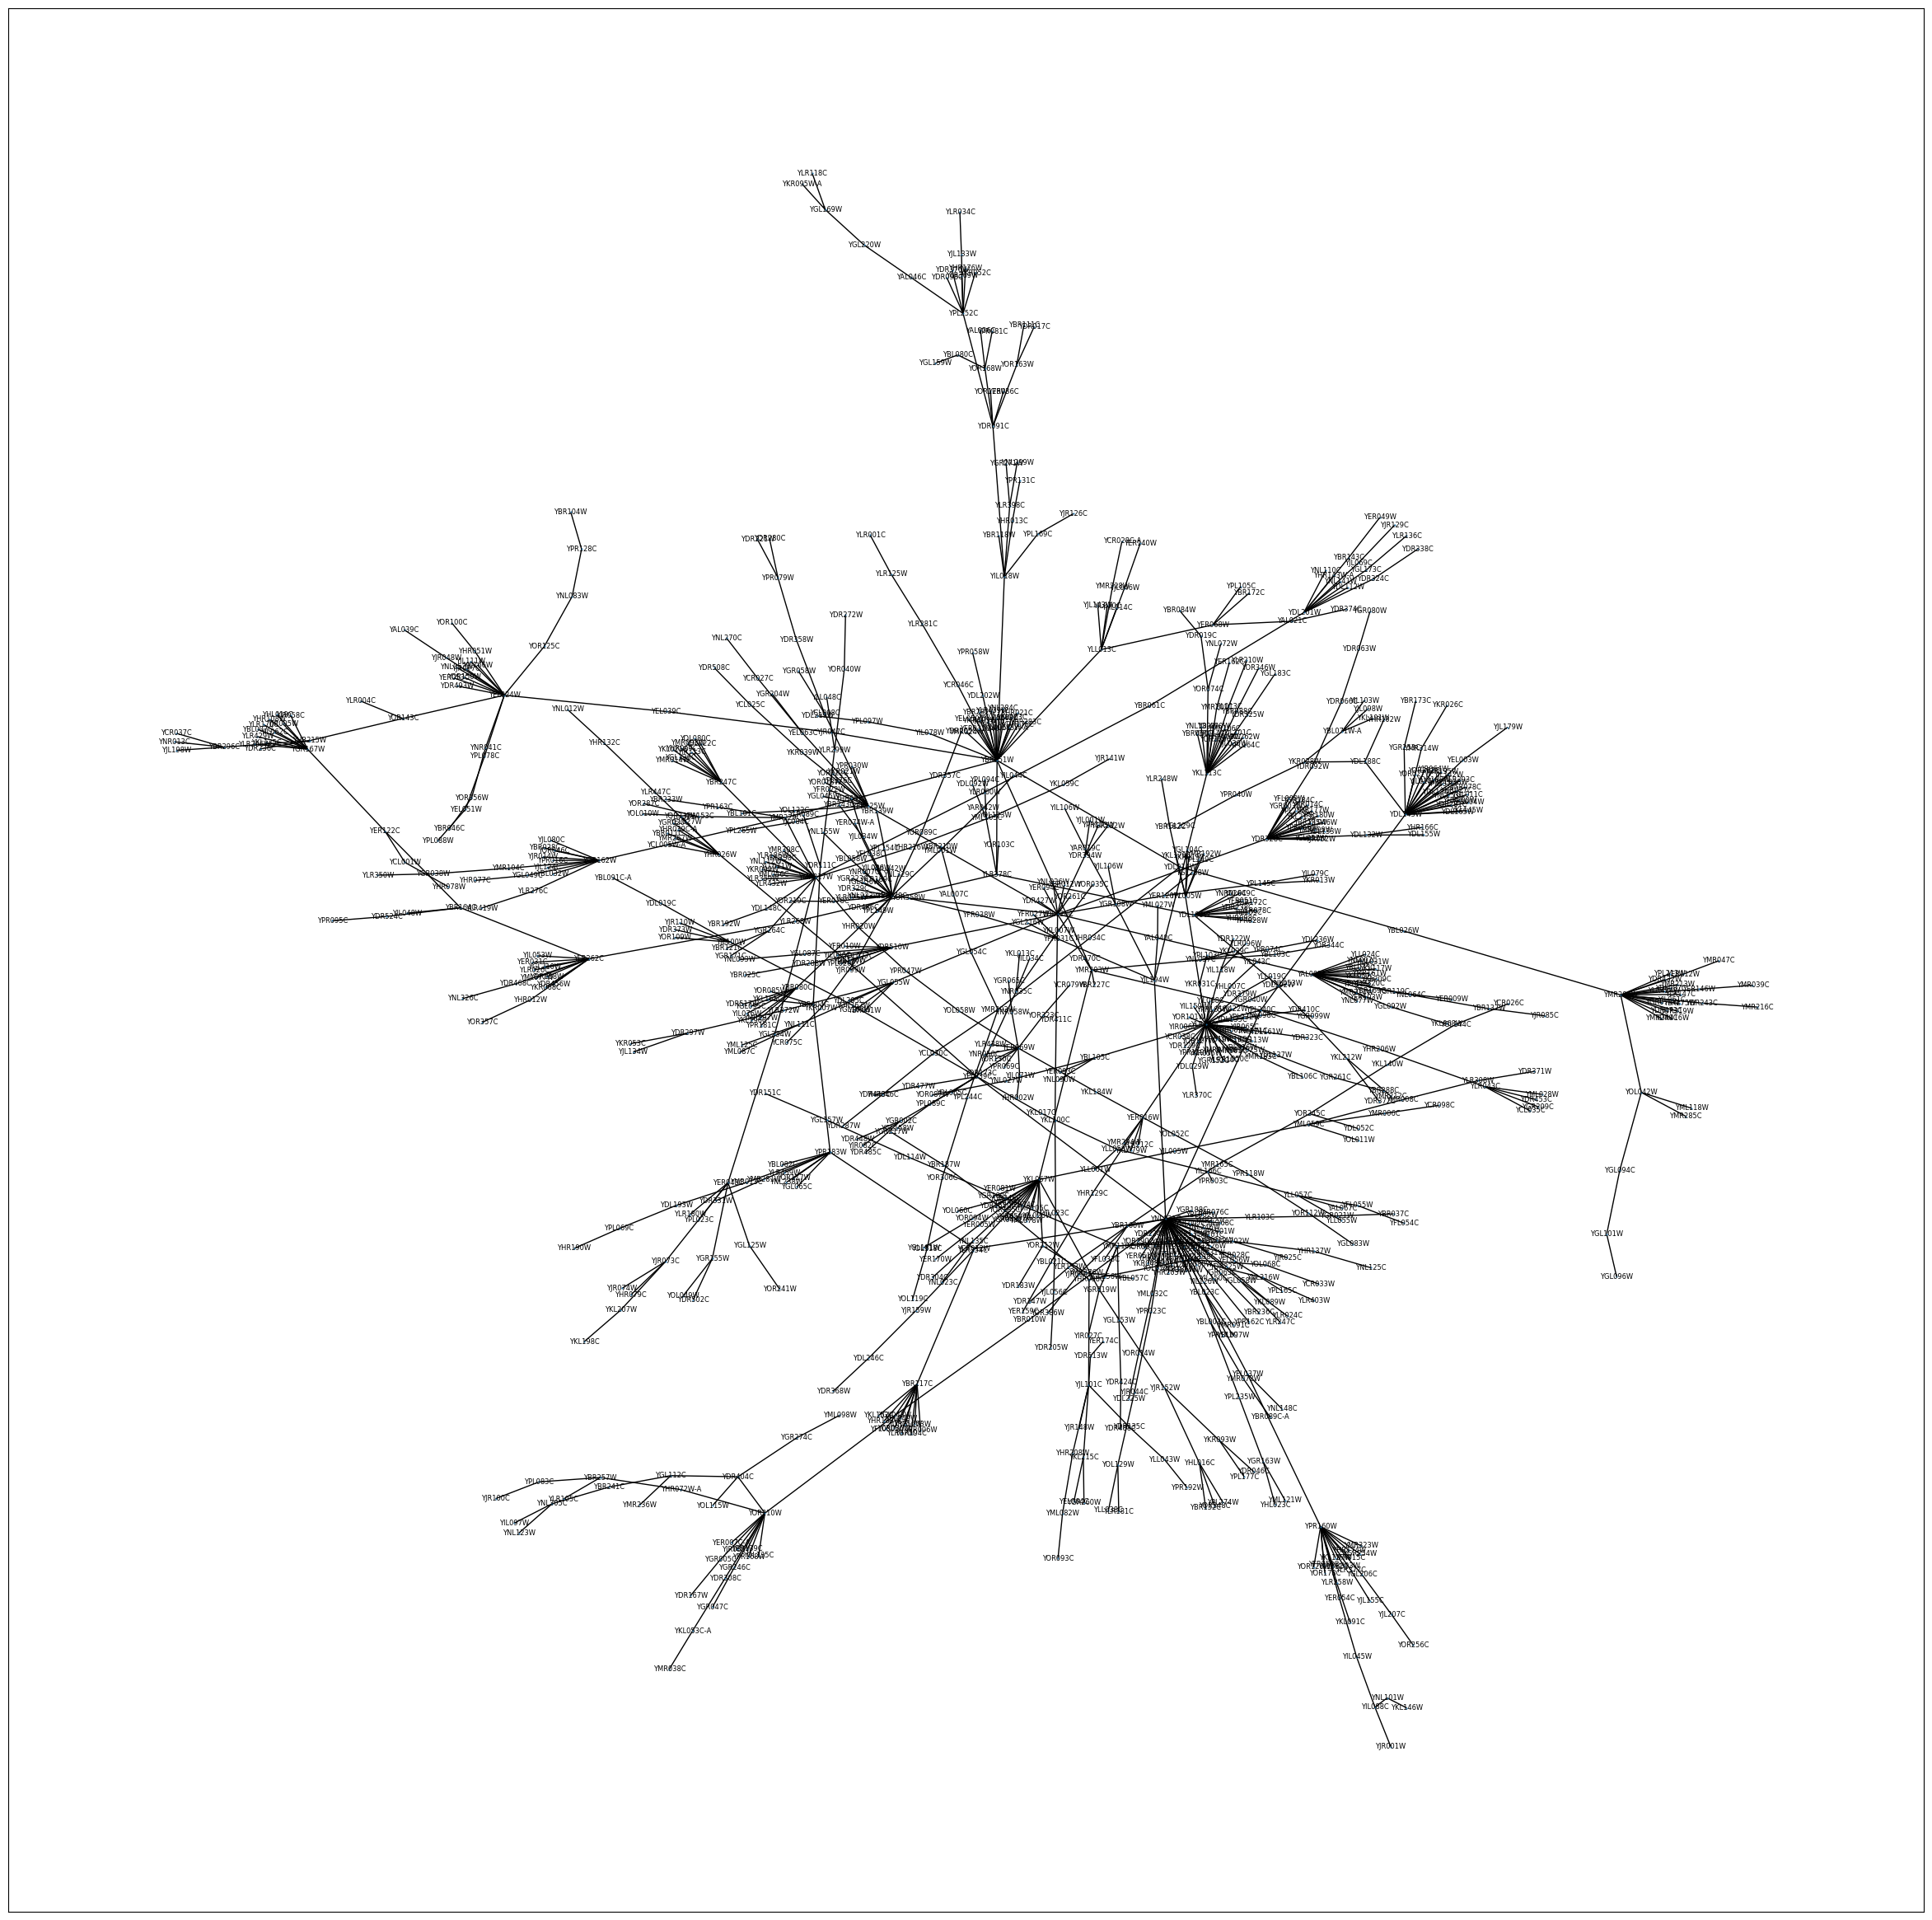

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))
nx.draw_networkx(ST, with_labels=True, node_size=0.25, font_size=6)
plt.show()

From here, we aim to narrow down this list of intermediate nodes to some quality candidate nodes for experiments.